This is an illustration of a very simple generative adversarial network, built with TensorFlow. It generates images that look like handwritten digits from the MNIST dataset.


The code here is written for TensorFlow v0.12, but can be made to run on earlier versions with some quick changes—in particular, replacing `tf.global_variable_initializer()` with `tf.initialize_all_variables()`. This script sends very helpful output to TensorBoard; to make it work with TensorBoard v0.11 and earlier, replace `tf.summary.scalar()` and `tf.summary.image()` with `tf.scalar_summary()` and `tf.image_summary()`, respectively.

- This is a Deep Convolutional GAN
- The generator is a deconvolutional net
- The discriminator is a convolutional net
- Watch a GAN train https://www.youtube.com/watch?v=fN3egtFdA7s

The authors improved on the vanilla GAN by finding that

- Batch normalization is a must in both networks. https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png?w=1008 Batch normalization potentially helps in two ways: faster learning and higher overall accuracy. The improved method also allows you to use a higher learning rate, potentially providing another boost in speed. normalization is often used as a pre-processing step to make the data comparable across features. batch normalizations is doing it everywhere
- ReLU activations are your friend (almost always).



GANS are hard to train

Without the right hyperparameters, network architecture, and training procedure, 
there is a high chance that either the generator or discriminator will overpower the other. 

A common case of this is the situation where the generator is able to find a flaw in the discriminator 
by repeatedly outputting an image that fits the data distribution the discriminator is looking for, 
but is nowhere close to being a readable MNIST digit. The generator has collapsed onto a single point, 
and therefore we won’t output a variety of digits.

There are also cases where the discriminator becomes
too powerful and is able to easily make the distinction between real and fake images.


The mathematical intuition behind this phenomenon lies in that GANs are typically trained using gradient 
descent techniques that are designed to find the minimum value of a cost function, rather than to find 
the Nash equilibrium of a game. When used to seek for a Nash equilibrium, these algorithms may fail to 
converge. Further research into game theory and stable optimization techniques may result in GANs that 
are as easy to train as ConvNets!

![Image of Yaktocat](https://cdn-images-1.medium.com/max/2000/1*39Nnni_nhPDaLu9AnTLoWw.png)

In [1]:
import tensorflow as tf #machine learning
import numpy as np #matrix math
import datetime #logging the time for model checkpoints and training
import matplotlib.pyplot as plt #visualize results
%matplotlib inline

#Step 1 - Collect dataset
#MNIST - handwritten character digits ~50K training and validation images + labels, 10K testing
from tensorflow.examples.tutorials.mnist import input_data
#will ensure that the correct data has been downloaded to your 
#local training folder and then unpack that data to return a dictionary of DataSet instances.
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


![Image of Yaktocat](https://image.slidesharecdn.com/tensorflowppt-160408142819/95/tensorflow-4-638.jpg?cb=1460125744)

In a clever structure suggested by [Adit Deshpande](https://adeshpande3.github.io/), the discriminator and generator networks will sit inside separate functions that we can call as needed.

Here's the discriminator network. It takes `x_image` and returns a real/fake classification. As you'll see below, we can either feed `x_image` through a placeholder, or from another tensor—for instance, the output of the generator.

This network structure is taken directly from TensorFlow's [Deep MNIST for Experts](https://www.tensorflow.org/tutorials/mnist/pros/) tutorial.

![Image of Yaktocat](https://ai2-s2-public.s3.amazonaws.com/figures/2016-11-08/42f6f5454dda99d8989f9814989efd50fe807ee8/3-Figure1-1.png)

In [2]:
def discriminator(x_image, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # These search for 32 different 5 x 5 pixel features
    #We’ll start off by passing the image through a convolutional layer. 
    #First, we create our weight and bias variables through tf.get_variable. 
    #Our first weight matrix (or filter) will be of size 5x5 and will have a output depth of 32. 
    #It will be randomly initialized from a normal distribution.
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    #tf.constant_init generates tensors with constant values.
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    #tf.nn.conv2d() is the Tensorflow’s function for a common convolution.
    #It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case). 
    #The next argument is the filter/weight matrix. Finally, you can also change the stride and 
    #padding of the convolution. Those two values affect the dimensions of the output volume.
    #"SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
    #it will add the extra column to the right,
    #strides = [batch, height, width, channels]
    d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    #add the bias
    d1 = d1 + d_b1
    #squash with nonlinearity (ReLU)
    d1 = tf.nn.relu(d1)
    ##An average pooling layer performs down-sampling by dividing the input into 
    #rectangular pooling regions and computing the average of each region. 
    #It returns the averages for the pooling regions.
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #As with any convolutional neural network, this module is repeated, 
    # Second convolutional and pool layers
    # These search for 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

     #and then followed by a series of fully connected layers. 
    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    #The last fully-connected layer holds the output, such as the class scores.
    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))

    #At the end of the network, we do a final matrix multiply and 
    #return the activation value. 
    #For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.
    # Final layer
    d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1

    return d4

And here's the generator. When it's called, it starts by creating a batch of random noise from the latente space $z$, then passes it through a handful of convolutions to produce a 28 x 28 image.

This structure is borrowed [from Tim O'Shea](http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html).

In [3]:
#You can think of the generator as being a kind of reverse ConvNet. With CNNs, the goal is to 
#transform a 2 or 3 dimensional matrix of pixel values into a single probability. A generator, 
#however, seeks to take a d-dimensional noise vector and upsample it to become a 28 x 28 image. 
#ReLUs are then used to stabilize the outputs of each layer.
#example of CNN blocks http://cs231n.github.io/convolutional-networks/#fc

#it takes random inputs, and eventually mapping them down to a [1,28,28] pixel to match the MNIST data shape.  
#Be begin by generating a dense 14×14 set of values, and then run through a handful of filters of
#varying sizes and numbers of channels
#weight matrices get progressively smaller

def generator(batch_size, z_dim):
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    #first deconv block
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

Here we set up our losses and optimizers.

- The upside-down capital delta symbol denotse the gradient of the generator
- m is the number of samples
- Sigma notation tells you to sum up the function evaluated at particular points determined by the little numbers on top and below the big sigma. It is used to add a series of numbers.

![Image of Yaktocat](https://cdn-images-1.medium.com/max/1600/1*V4nu4ThcHFQXmWKxx9lhbA.png)
The gradient ascent expression for the discriminator. The first term corresponds to optimizing the probability that the real data (x) is rated highly. The second term corresponds to optimizing the probability that the generated data G(z) is rated poorly. Notice we apply the gradient to the discriminator, not the generator.

Gradient methods generally work better optimizing log⁡p(x) than p(x) because the gradient of log⁡p(x) is generally more well-scaled. That is, it has a size that consistently and helpfully reflects the objective function's geometry, making it easier to select an appropriate step size and get to the optimum in fewer steps. The computer uses a limited digit floating point representation of fractions, multiplying so many probabilities is guaranteed to be very very close to zero. With log, we don't have this issue.

The generator is then optimized in order to increase the probability of the generated data being rated highly.

![Image of Yaktocat](https://cdn-images-1.medium.com/max/1600/1*njOrO3uNzUH1dZb7-i-dhw.png)
The gradient descent expression for the generator. The term corresponds to optimizing the probability that the generated data G(z) is rated highly. Notice we apply the gradient to the generator network, not the discriminator.

By alternating gradient optimization between the two networks using these expressions on new batches of real and generated data each time, the GAN will slowly converge to producing data that is as realistic as the network is capable of modeling. 

In [4]:
sess = tf.Session()

batch_size = 50
z_dimensions = 100

x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator

#One of the trickiest parts about understanding GANs is that the loss function is a little bit more complex than that
#of a traditional CNN classifiers (For those, a simple MSE or Hinge Loss would do the trick). 
#If you think back to the introduction, a GAN can be thought of as a zero sum minimax game. 
#The generator is constantly improving to produce more and more realistic images, while the discriminator is 
#trying to get better and better at distinguishing between real and generated images.
#This means that we need to formulate loss functions that affect both networks. 
#Let’s take a look at the inputs and outputs of our networks.

Gz = generator(batch_size, z_dimensions)
# Gz holds the generated images
#g(z)

Dx = discriminator(x_placeholder)
# Dx hold the discriminator's prediction probabilities
# for real MNIST images
#d(x)

Dg = discriminator(Gz, reuse=True)
# Dg holds discriminator prediction probabilities for generated images
#d(g(z))



#So, let’s first think about what we want out of our networks. We want the generator network to create 
#images that will fool the discriminator. The generator wants the discriminator to output a 1 (positive example).
#Therefore, we want to compute the loss between the Dg and label of 1. This can be done through 
#the tf.nn.sigmoid_cross_entropy_with_logits function. This means that the cross entropy loss will 
#be taken between the two arguments. The "with_logits" component means that the function will operate 
#on unscaled values. Basically, this means that instead of using a softmax function to squish the output
#activations to probability values from 0 to 1, we simply return the unscaled value of the matrix multiplication.
#Take a look at the last line of our discriminator. There's no softmax or sigmoid layer at the end.
#The reduce mean function just takes the mean value of all of the components in the matrixx returned 
#by the cross entropy function. This is just a way of reducing the loss to a single scalar value, 
#instead of a vector or matrix.
#https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))


#Now, let’s think about the discriminator’s point of view. Its goal is to just get the correct labels 
#(output 1 for each MNIST digit and 0 for the generated ones). We’d like to compute the loss between Dx 
#and the correct label of 1 as well as the loss between Dg and the correct label of 0.
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discriminator
# Increasing from 0.001 in GitHub version
with tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
    #Next, we specify our two optimizers. In today’s era of deep learning, Adam seems to be the
    #best SGD optimizer as it utilizes adaptive learning rates and momentum. 
    #We call Adam's minimize function and also specify the variables that we want it to update.
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

    # Train the generator
    # Decreasing from 0.004 in GitHub version
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

Here's where we pass helpful summary scalars and sample images to TensorBoard.

In [ ]:
#Outputs a Summary protocol buffer containing a single scalar value.
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
writer = tf.summary.FileWriter(logdir, sess.graph)
print(logdir)

We want to eventually reach a point where the discriminator correctly classifies nearly all real MNIST images as MNIST images, and classifies generated images as MNIST images about 50% of the time. There are several failure modes that we need to avoid:
* **Discriminator losses approach zero**: this leaves practically no gradients for the generator's optimizer.
* **Discriminator losses rise unbounded on generated images**: similarly, this leaves practically no gradient for the discriminator to improve, and the generator's training stalls, too, since the gradients it's reading suggest that it has achieved perfect performance.
* **Divergent discriminator accuracy**: the discriminator learns a shortcut by either classifying everything as real or everything as generated. You can detect this by checking the discriminator's losses on generated images against the discriminator's losses on real images.

To stay balanced between these, we use a controller in the training loop that runs each of the three training operations depending on their losses. Qualitatively speaking, the most rapid improvements in output come when the generator and discriminator are evenly matched; the controller avoids running a training operation when its network shows signs of overpowering the others.

Here's our training loop. You'll need a writable directory in your current working directory called `tensorboard` for TensorBoard logs, and another one called `models` to store the five most recent checkpoints.

Recognizable results should begin to appear before 10,000 cycles, and will improve after that. On a fast GPU machine, you can make it to 10,000 cycles in less than 10 minutes. It could take around 10 times as long to run on a desktop CPU. There are lots of random numbers involved, so you'll get different results every time you run this. In particular, it's likely to stall for upwards of 2,000 cycles at a time early on, but it should recover on its own.

TRAINING STEP 0 AT 2017-04-25 18:40:06.746826
Discriminator classification [-0.00066344]


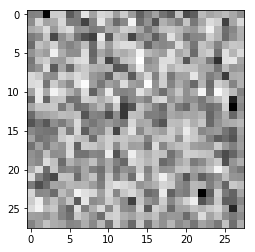

Discriminator classification [-0.00072882]


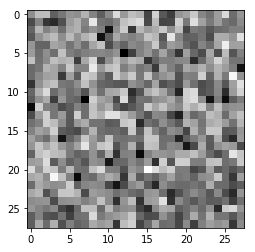

Discriminator classification [-0.00070926]


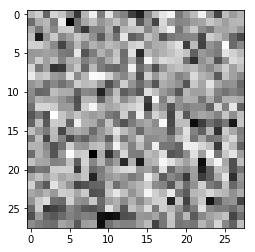

saved to models/pretrained_gan.ckpt-0


In [ ]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

#During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
#For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
#to obtain a probability score (this is the Dg variable we specified earlier).
#As we remember from our loss function, the cross entropy loss gets minimized, 
#and only the generator’s weights and biases get updated.
#We'll do the same for the discriminator update. We’ll be taking a batch of images 
#from the mnist variable we created way at the beginning of our program.
#These will serve as the positive examples, while the images in the previous section are the negative ones.

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(50000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_fake_count += 1

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        g_count += 1

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_real_count += 1

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                    d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 1000 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(3, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 5000 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)

Now let's see some of the images produced by the generator. (The generator has also been sending its images to TensorBoard regularly; click the "images" tab in TensorBoard to see them as this runs.)

And, as a sanity check, let's look at some real MNIST images and make sure that the discriminator correctly classifies them as real MINST images.

In [ ]:
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()

One note that I’d like to make is that GANs are notoriously difficult to train. 
Without the right hyperparameters, network architecture, and training procedure, 
there is a high chance that either the generator or discriminator will overpower the other. 
A common case of this is the situation where the generator is able to find a flaw in the discriminator 
by repeatedly outputting an image that fits the data distribution the discriminator is looking for, 
but is nowhere close to being a readable MNIST digit. The generator has collapsed onto a single point, 
and therefore we won’t output a variety of digits. There are also cases where the discriminator becomes
too powerful and is able to easily make the distinction between real and fake images.
The mathematical intuition behind this phenomenon lies in that GANs are typically trained using gradient 
descent techniques that are designed to find the minimum value of a cost function, rather than to find 
the Nash equilibrium of a game. When used to seek for a Nash equilibrium, these algorithms may fail to 
converge. Further research into game theory and stable optimization techniques may result in GANs that 
are as easy to train as ConvNets!